In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import uuid
from langchain_core.messages import HumanMessage
from src.ai.autodf_ml_assistant import build_graph

In [4]:
async def visualize_dataframe_assistant_graph():
    graph = await build_graph()
    
    return graph

In [5]:
assistant_graph = await visualize_dataframe_assistant_graph()
print(assistant_graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	conversation(conversation)
	pandas_agent(pandas_agent)
	default_assistant(default_assistant)
	ml_agent(ml_agent)
	__end__([<p>__end__</p>]):::last
	__start__ --> conversation;
	default_assistant --> __end__;
	ml_agent --> __end__;
	pandas_agent --> __end__;
	conversation -.-> pandas_agent;
	conversation -.-> default_assistant;
	conversation -.-> ml_agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



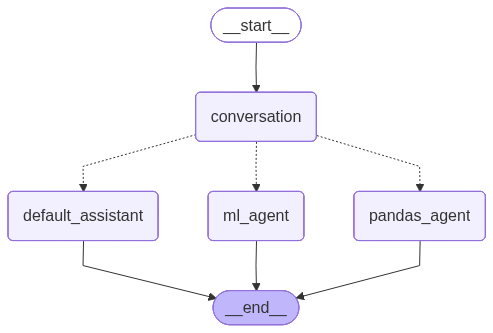

In [6]:
assistant_graph

In [7]:
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id" : thread_id}}

In [8]:
async def log_assistant_graph_steps(query: str, config: dict):
    step = 1
    current_tool = None
    async for token, metadata in assistant_graph.astream(
            {"messages": [HumanMessage(content=query)]}, config=config, stream_mode="messages"
    ):
        current_node = metadata.get('langgraph_node', 'unknown')
        
        # Check if this is a tool call by looking at the message content
        if hasattr(token, 'tool_calls') and token.tool_calls:
            for tool_call in token.tool_calls:
                tool_name = tool_call.get('name', 'unknown_tool')
                print(f"\n🔧 Calling tool: {tool_name}")
                current_tool = tool_name
        
        # Print step metadata when it changes
        if metadata['langgraph_step'] == step:
            print(f"\n🔄 Step {step}: Node '{current_node}'")
            if current_node == 'tools' and current_tool:
                print(f"   └── Executing tool: {current_tool}")
            print("Metadata", metadata, "\n")
            step += 1
            
        print(token.content, end='', flush=True)

In [9]:
query = "List the columns of my data."
await log_assistant_graph_steps(query, config)


🔄 Step 1: Node 'conversation'
Metadata {'thread_id': '53710a89-bb8a-498b-8454-3b0cf5ce2be6', 'langgraph_step': 1, 'langgraph_node': 'conversation', 'langgraph_triggers': ('branch:to:conversation', 'start:conversation'), 'langgraph_path': ('__pregel_pull', 'conversation'), 'langgraph_checkpoint_ns': 'conversation:2c5edf8c-dd37-edda-4e9a-ea3d5a07a7b9', 'checkpoint_ns': 'conversation:2c5edf8c-dd37-edda-4e9a-ea3d5a07a7b9', 'ls_provider': 'ollama', 'ls_model_name': 'gpt-oss:20b', 'ls_model_type': 'chat', 'ls_temperature': 0.7} 

pandas_agent
🔧 Calling tool: python_repl_ast

🔄 Step 2: Node 'tools'
   └── Executing tool: python_repl_ast
Metadata {'thread_id': '53710a89-bb8a-498b-8454-3b0cf5ce2be6', 'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ('branch:to:tools',), 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'pandas_agent:abd6df24-9cd2-af5d-c897-561950df0f3d|tools:bd1d608b-4194-2576-f002-6bfe613b933d', 'checkpoint_ns': 'pandas_agent:abd6df

In [10]:
query = "please give me descriptive statistics of the data"
await log_assistant_graph_steps(query, config)

pandas_agent
🔄 Step 1: Node 'agent'
Metadata {'thread_id': '53710a89-bb8a-498b-8454-3b0cf5ce2be6', 'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent', 'start:agent', 'tools'), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'pandas_agent:8e755231-c0d4-642d-9119-11fb30f1d0e2|agent:4e4b2501-947e-e9f0-f26e-88b718abd327', 'checkpoint_ns': 'pandas_agent:8e755231-c0d4-642d-9119-11fb30f1d0e2', 'ls_provider': 'ollama', 'ls_model_name': 'gpt-oss:20b', 'ls_model_type': 'chat', 'ls_temperature': 0.7} 


🔄 Step 2: Node 'tools'
   └── Executing tool: python_repl_ast
Metadata {'thread_id': '53710a89-bb8a-498b-8454-3b0cf5ce2be6', 'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ('branch:to:tools',), 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'pandas_agent:8e755231-c0d4-642d-9119-11fb30f1d0e2|tools:4c8f9288-ae0c-c48f-58c6-50de3b18fcd8', 'checkpoint_ns': 'pandas_agent:8e755231-c0d4-642d-911

In [11]:
query = "Can we do predictive modeling on this dataset?"
await log_assistant_graph_steps(query, config)

ml_agent
🔄 Step 1: Node 'agent'
Metadata {'thread_id': '53710a89-bb8a-498b-8454-3b0cf5ce2be6', 'langgraph_step': 1, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent', 'start:agent', 'tools'), 'langgraph_path': ('__pregel_pull', 'agent'), 'langgraph_checkpoint_ns': 'ml_agent:b823bfc4-a1b5-8f5f-85fb-e4e839c11ab4|agent:bd82daaa-5bc2-e682-d6cb-e278f7eabd54', 'checkpoint_ns': 'ml_agent:b823bfc4-a1b5-8f5f-85fb-e4e839c11ab4', 'ls_provider': 'ollama', 'ls_model_name': 'gpt-oss:20b', 'ls_model_type': 'chat', 'ls_temperature': 0.7} 

Absolutely! Your dataset is ready for predictive modeling.  
Here’s a quick roadmap, and I’ll actually build a model for you:

| Step | What to do | Why it matters |
|------|------------|----------------|
| **1. Pick a target** | Decide which column you want to predict. Common choices here are `disease_risk` (0/1) or a health‑risk score. | The model’s objective is defined by the target. |
| **2. Split data** | Usually 80 % train / 20 % test (or use

2025-10-04 12:18:58,846 - dataframe-chatbot - INFO - #Train examples = 80000
2025-10-04 12:18:58,846 - dataframe-chatbot - INFO - #Test examples = 20000
2025-10-04 12:19:01,716 - dataframe-chatbot - INFO - Best Parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
2025-10-04 12:19:01,716 - dataframe-chatbot - INFO - Best CV Macro F1: 0.43233518885584815
2025-10-04 12:19:01,716 - dataframe-chatbot - INFO - ----------

2025-10-04 12:19:01,739 - dataframe-chatbot - INFO - ---- Train Results ----
2025-10-04 12:19:01,740 - dataframe-chatbot - INFO - Recall (weighted) = 0.752725
2025-10-04 12:19:01,740 - dataframe-chatbot - INFO - Precision (weighted) = 0.7378396531690224
2025-10-04 12:19:01,740 - dataframe-chatbot - INFO - F1-score (weighted) = 0.6488626347179016
2025-10-04 12:19:01,741 - dataframe-chatbot - INFO - ----------

2025-10-04 12:19:01,741 - dataframe-chatbot - INFO - ---- Test Results ----
2025-10-04 12:19:01,741 - dataframe-chatbot - INFO - Recall (weighte


🔄 Step 2: Node 'tools'
   └── Executing tool: python_repl_ast
Metadata {'thread_id': '53710a89-bb8a-498b-8454-3b0cf5ce2be6', 'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ('branch:to:tools',), 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'ml_agent:b823bfc4-a1b5-8f5f-85fb-e4e839c11ab4|tools:edb62824-2e2b-759c-51b6-9c423fd5700e', 'checkpoint_ns': 'ml_agent:b823bfc4-a1b5-8f5f-85fb-e4e839c11ab4'} 

{"model_uri": "/home/davit/medium/dataframe_chatbot/models/decision_tree/model.joblib", "metrics": {"train": {"Recall (weighted)": 0.752725, "Precision (weighted)": 0.7378396531690224, "F1-score (weighted)": 0.6488626347179016}, "test": {"Recall (weighted)": 0.75065, "Precision (weighted)": 0.6160527934600677, "F1-score (weighted)": 0.6454638211752493}}}
🔄 Step 3: Node 'agent'
Metadata {'thread_id': '53710a89-bb8a-498b-8454-3b0cf5ce2be6', 'langgraph_step': 3, 'langgraph_node': 'agent', 'langgraph_triggers': ('branch:to:agent', 'start:agent', '